In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

from surv_ai.lib.log import logger, AgentLogLevel
import logging

logger.set_log_level(AgentLogLevel.INTERNAL)
logging.basicConfig(level=logging.INFO)

In [3]:
from surv_ai import (
    GPTClient,
    Survey,
    ToolBelt,
    GoogleCustomSearchTool,
    Knowledge
)

client = GPTClient(os.environ["OPEN_AI_API_KEY"])

tool_belt = ToolBelt(
    tools=[
        GoogleCustomSearchTool(
            google_api_key=os.environ["GOOGLE_API_KEY"],
            google_search_engine_id=os.environ["GOOGLE_SEARCH_ENGINE_ID"],
            start_date="2023-01-01",
            end_date="2023-05-01",
            n_pages=10,
        )
    ]
)
base_knowledge = [
    Knowledge(
        text="It is currently 2023/05/01, all the articles are from 2023.",
        source="Additional context",
    ),
]

survey = Survey(
    client=client,
    tool_belt=tool_belt,
    base_knowledge=base_knowledge,
    max_knowledge_per_agent=3,
    n_agents=10,
    max_concurrency=5,
)

await survey.conduct(
    "California experienced a significant amount of rainfall this winter.",
)  # This should always returns high a confidence agreement.

INFO:surv_ai:...Using tool: SEARCH("California rainfall winter 2023")...
INFO:surv_ai:......Retrieving www.nytimes.com page with title A Very Wet Winter Has Eased California’s Drought, but Water Woes Remain......
INFO:surv_ai:......Retrieving CNN page with title Record snowpack, nearly full reservoirs: Here's the state of California's drought after an epic winter | CNN......
INFO:surv_ai:......Retrieving Washington Post page with title The science behind California’s extremely wet winter, in maps......
INFO:surv_ai:......Retrieving www.nytimes.com page with title What Does All This Rain Mean for California’s Drought?......
INFO:surv_ai:......Retrieving www.nytimes.com page with title How Do California’s Storms Weigh In Compared With History’s Big Ones?......
INFO:surv_ai:......Retrieving Washington Post page with title New winter storm could push California’s snowpack to record high......
INFO:surv_ai:......Retrieving CNN page with title Snowfall tops 6.5 feet and rainfall tops 5 inche

SurveyResponse(in_favor=10, against=0, undecided=0, error=0, percent_in_favor=1.0, uncertainty=0.0)

In [4]:
from surv_ai import (
    GPTClient,
    Survey,
    ToolBelt,
    GoogleCustomSearchTool,
    Knowledge
)

client = GPTClient(os.environ["OPEN_AI_API_KEY"])

tool_belt = ToolBelt(
    tools=[
        GoogleCustomSearchTool(
            google_api_key=os.environ["GOOGLE_API_KEY"],
            google_search_engine_id=os.environ["GOOGLE_SEARCH_ENGINE_ID"],
            start_date="2023-01-01",
            end_date="2023-05-01",
            n_pages=10,
        )
    ]
)
base_knowledge = [
    Knowledge(
        text="It is currently 2023/05/01, all the articles are from 2023.",
        source="Additional context",
    ),
]

survey = Survey(
    client=client,
    tool_belt=tool_belt,
    base_knowledge=base_knowledge,
    max_knowledge_per_agent=3,
    n_agents=10,
)

await survey.conduct(
    "California experienced little rainfall this winter.",
)  # This should always returns a high confidence disagreement.

INFO:surv_ai:...Using tool: SEARCH("California little rainfall winter")...
INFO:surv_ai:......Retrieving www.nytimes.com page with title A Very Wet Winter Has Eased California’s Drought, but Water Woes Remain......
INFO:surv_ai:......Retrieving CNN page with title Record snowpack, nearly full reservoirs: Here's the state of California's drought after an epic winter | CNN......
INFO:surv_ai:......Retrieving www.nytimes.com page with title What Does All This Rain Mean for California’s Drought?......
INFO:surv_ai:......Retrieving Washington Post page with title In California, a drought turned to floods. Forecasters didn’t see it coming.......
INFO:surv_ai:......Retrieving www.nytimes.com page with title Despite Rain Storms, California Is Still in Drought......
INFO:surv_ai:......Retrieving www.nytimes.com page with title Why the West Got Buried in Snow, While the East Got Little......
INFO:surv_ai:......Retrieving www.nytimes.com page with title More Rain and Snow Are Lashing California..

SurveyResponse(in_favor=1, against=9, undecided=0, error=0, percent_in_favor=0.1, uncertainty=0.0)

In [6]:
from surv_ai import (
    GPTClient,
    Model,
    ToolBelt,
    GoogleCustomSearchTool,
    Knowledge,
    Survey,
    SurveyParameter
)


client = GPTClient(os.environ["OPEN_AI_API_KEY"])

def build_parameter(date_range: tuple[str, str]):
    tool_belt = ToolBelt(
        tools=[
            GoogleCustomSearchTool(
                google_api_key=os.environ["GOOGLE_API_KEY"],
                google_search_engine_id=os.environ["GOOGLE_SEARCH_ENGINE_ID"],
                n_pages=30,
                start_date=date_range[0],
                end_date=date_range[1],
            ),
        ],
    )
    base_knowledge = [
        Knowledge(
            text=f"It is currently {date_range[0]}. The included articles were published between {date_range[0]} and {date_range[1]}",
            source="Additional context",
        ),
        Knowledge(
            text=f"Democrats currently own the Vice Presidency, thus a tie should still be considered a win for democrats.",
            source="Additional context",
        )
    ]
    return SurveyParameter(
        independent_variable=date_range[1],
        kwargs={
            "client": client,
            "n_agents": 100,
            "max_knowledge_per_agent":5,
            "max_concurrency": 20,
            "tool_belt": tool_belt,
            "base_knowledge": base_knowledge,
        },
    )

date_ranges = [
    ('2022-05-01', '2022-06-01'),
    ('2022-06-01', '2022-07-01'),
    ('2022-07-01', '2022-08-01'),
    ('2022-08-01', '2022-09-01'),
    ('2022-09-01', '2022-10-01'),
    ('2022-10-01', '2022-11-05'),
]

model = Model(
    Survey,
    parameters=[build_parameter(date_range) for date_range in date_ranges],
)

democrat_results = await model.build(
    "Democrats are favored to maintain control of the Senate in the 2022 November Midterm elections.",
)

INFO:surv_ai:...Using tool: SEARCH("2022 senate election predictions")...
INFO:surv_ai:......Retrieving NBC News page with title Primary election 2022 live updates: Pa. GOP Senate race in dead heat......
INFO:surv_ai:......Retrieving CNN page with title The 10 Senate seats most likely to flip in 2022 | CNN Politics......
INFO:surv_ai:......Retrieving Washington Post page with title Opinion | The GOP midterm wave is set — and Democrats can’t do anything about it......
INFO:surv_ai:......Retrieving Washington Post page with title A decision to overturn Roe v. Wade might upend the midterms......
INFO:surv_ai:......Retrieving www.nbcnews.com page with title Pennsylvania Primary Senate Election Live Results 2022 – NBC News......
INFO:surv_ai:......Retrieving www.nytimes.com page with title 2022 Midterm Primary Elections: Pennsylvania G.O.P. Senate Race Is Deadlocked; Cawthorn Falls to Defeat (Published 2022)......
INFO:surv_ai:......Retrieving NBC News page with title Oz, McCormick remain o

In [ ]:
from surv_ai import (
    GPTClient,
    Model,
    ToolBelt,
    GoogleCustomSearchTool,
    Knowledge,
    Survey,
    SurveyParameter
)


client = GPTClient(os.environ["OPEN_AI_API_KEY"])

def build_parameter(date_range: tuple[str, str]):
    tool_belt = ToolBelt(
        tools=[
            GoogleCustomSearchTool(
                google_api_key=os.environ["GOOGLE_API_KEY"],
                google_search_engine_id=os.environ["GOOGLE_SEARCH_ENGINE_ID"],
                n_pages=30,
                start_date=date_range[0],
                end_date=date_range[1],
            ),
        ],
    )
    base_knowledge = [
        Knowledge(
            text=f"It is currently {date_range[0]}. The included articles were published between {date_range[0]} and {date_range[1]}",
            source="Additional context",
        ),
    ]
    return SurveyParameter(
        independent_variable=date_range[1],
        kwargs={
            "client": client,
            "n_agents": 100,
            "max_knowledge_per_agent":5,
            "max_concurrency": 20,
            "tool_belt": tool_belt,
            "base_knowledge": base_knowledge,
        },
    )

date_ranges = [
    ('2022-05-01', '2022-06-01'),
    ('2022-06-01', '2022-07-01'),
    ('2022-07-01', '2022-08-01'),
    ('2022-08-01', '2022-09-01'),
    ('2022-09-01', '2022-10-01'),
    ('2022-10-01', '2022-11-05'),
]

model = Model(
    Survey,
    parameters=[build_parameter(date_range) for date_range in date_ranges],
)

republican_results = await model.build(
    "Republicans are favored to maintain control of the Senate in the 2022 November Midterm elections.",
)

In [ ]:
from surv_ai import (
    GPTClient,
    Model,
    ToolBelt,
    GoogleCustomSearchTool,
    Knowledge,
    Survey,
    SurveyParameter
)


client = GPTClient(os.environ["OPEN_AI_API_KEY"])

def build_parameter(date_range: tuple[str, str]):
    tool_belt = ToolBelt(
        tools=[
            GoogleCustomSearchTool(
                google_api_key=os.environ["GOOGLE_API_KEY"],
                google_search_engine_id=os.environ["GOOGLE_SEARCH_ENGINE_ID"],
                n_pages=30,
                start_date=date_range[0],
                end_date=date_range[1],
            ),
        ],
    )
    base_knowledge = [
        Knowledge(
            text=f"It is currently {date_range[0]}. The included articles were published between {date_range[0]} and {date_range[1]}",
            source="Additional context",
        ),
    ]
    return SurveyParameter(
        independent_variable=date_range[1],
        kwargs={
            "client": client,
            "n_agents": 100,
            "max_knowledge_per_agent":5,
            "max_concurrency": 20,
            "tool_belt": tool_belt,
            "base_knowledge": base_knowledge,
        },
    )

date_ranges = [
    ('2022-05-01', '2022-06-01'),
    ('2022-06-01', '2022-07-01'),
    ('2022-07-01', '2022-08-01'),
    ('2022-08-01', '2022-09-01'),
    ('2022-09-01', '2022-10-01'),
    ('2022-10-01', '2022-11-05'),
]

model = Model(
    Survey,
    parameters=[build_parameter(date_range) for date_range in date_ranges],
)

tie_results = await model.build(
    "Republicans and Democrats are likely to split control of the Senate 50/50 after the 2022 November Midterm elections.",
)

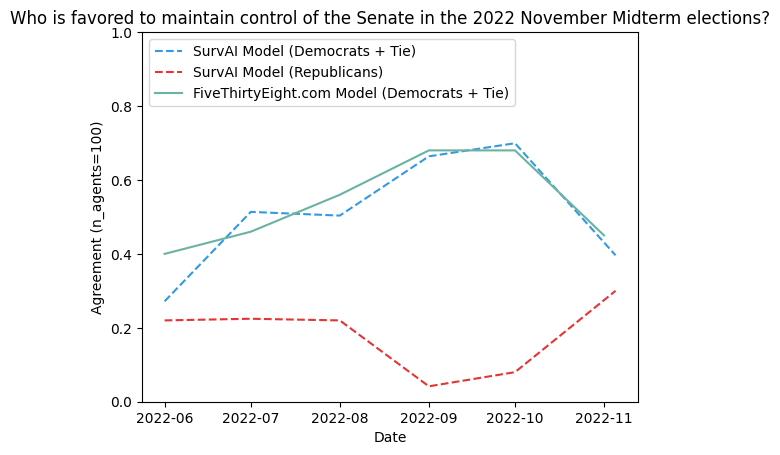

In [63]:
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import pyplot

COLOR_GROUND_TRUTH = "#69b3a2"
COLOR_MODEL_D = "#3399e6"
COLOR_MODEL_R = "#e63333"
COLOR_MODEL_TIE = "#333333"
  
variables_d = model.get_plot_variables(democrat_results)
variables_r = model.get_plot_variables(republican_results)
variables_t = model.get_plot_variables(tie_results)


# plotting the points 
pyplot.plot([datetime(int(r[0:4]), int(r[5:7]), int(r[8:10])) for r in variables_d[0]], [variables_d[1][i] + variables_t[1][i] for i in range(len(variables_d[1]))], color=COLOR_MODEL_D, linestyle="dashed", label="SurvAI Model (Democrats + Tie)")
pyplot.plot([datetime(int(r[0:4]), int(r[5:7]), int(r[8:10])) for r in variables_r[0]], variables_r[1], color=COLOR_MODEL_R, linestyle="dashed", label="SurvAI Model (Republicans)")
pyplot.plot([datetime(int(r[0:4]), int(r[4:6]), int(r[6:8])) for r in ['20220601', '20220701', '20220801', '20220901', '20221001', '20221101']], [1 - r for r in [0.60, 0.54, 0.44, 0.32, 0.32, 0.55]], color=COLOR_GROUND_TRUTH, label="FiveThirtyEight.com Model (Democrats + Tie)")

pyplot.ylabel("Agreement (n_agents=100)")
pyplot.xlabel("Date")

pyplot.legend(loc="upper left")

pyplot.ylim(0, 1)
  
# giving a title to my graph
pyplot.title('Who is favored to maintain control of the Senate in the 2022 November Midterm elections?')
  
# function to show the plot
pyplot.show()

In [ ]:
from surv_ai import (
    GPTClient,
    Model,
    ToolBelt,
    GoogleCustomSearchTool,
    Knowledge,
    Survey,
    SurveyParameter
)
client = GPTClient(os.environ["OPEN_AI_API_KEY"])

def build_parameter(date_range: tuple[str, str]):
    tool_belt = ToolBelt(
        tools=[
            GoogleCustomSearchTool(
                google_api_key=os.environ["GOOGLE_API_KEY"],
                google_search_engine_id=os.environ["GOOGLE_SEARCH_ENGINE_ID"],
                n_pages=30,
                start_date=date_range[0],
                end_date=date_range[1],
            ),
        ],
    )
    base_knowledge = [
        Knowledge(
            text=f"It is currently {date_range[0]}. The included articles were published between {date_range[0]} and {date_range[1]}",
            source="Additional context",
        ),
    ]
    return SurveyParameter(
        independent_variable=date_range[1],
        kwargs={
            "client": client,
            "n_agents": 100,
            "max_knowledge_per_agent":5,
            "max_concurrency": 20,
            "tool_belt": tool_belt,
            "base_knowledge": base_knowledge,
        },
    )

date_ranges = [
    ('2021-09-01', '2022-01-01'),
    ('2022-01-01', '2022-03-01'),
    ('2022-03-01', '2022-06-01'),
    ('2022-06-01', '2022-09-01'),
    ('2022-09-01', '2023-01-01'),
    ('2023-01-01', '2023-03-01'),
    ('2023-03-01', '2023-06-01'),
]

model = Model(
    Survey,
    parameters=[build_parameter(date_range) for date_range in date_ranges],
)

results = await model.build(
    "The United States economy looks like it is heading for a recession.",
)

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import pyplot


COLOR_GROUND_TRUTH = "#69b3a2"
COLOR_MODEL = "#3399e6"
  
variables = model.get_plot_variables(results)
fig, ax1 = plt.subplots()
fig.set_size_inches(10.5, 5)

ax2 = ax1.twinx()

# plotting the points 
ax1.plot([datetime(int(r[0:4]), int(r[5:7]), int(r[8:10])) for r in variables[0]], [1 - r for r in variables[1]], color=COLOR_MODEL, linestyle="dashed", label="Complement of SurVAI Model")
pyplot.plot([*[datetime(2022,i + 1,1) for i in range(12)], *[datetime(2023,i + 1,1) for i in range(6)]], [4766, 4500, 4328, 4545, 4123, 4108, 3825, 4145, 3924, 3585, 3770, 3943, 3895, 4136, 4045, 4105, 4136, 4172], color=COLOR_GROUND_TRUTH, label="S&P 500")

ax1.set_ylabel("Agreement (n_agents=100)")
pyplot.xlabel("Date")
ax2.set_ylabel("S&P 500")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
# giving a title to my graph
pyplot.title('"The United States economy looks like it is heading for a recession."')
  
# function to show the plot
pyplot.show()

In [ ]:
from surv_ai import (
    GPTClient,
    Model,
    ToolBelt,
    GoogleCustomSearchTool,
    Knowledge,
    Survey,
    SurveyParameter
)

client = GPTClient(os.environ["OPEN_AI_API_KEY"])

def build_parameter(news_source: str):
    tool_belt = ToolBelt(
        tools=[
            GoogleCustomSearchTool(
                google_api_key=os.environ["GOOGLE_API_KEY"],
                google_search_engine_id=os.environ["GOOGLE_SEARCH_ENGINE_ID"],
                n_pages=30,
                start_date="2023-05-01",
                end_date="2023-06-01",
                only_include_sources=[news_source]
            ),
        ],
    )
    base_knowledge = [
        Knowledge(
            text=f"It is currently 2023-06-01. The included articles were published between 2023-05-01 and 2023-06-01",
            source="Additional context",
        ),
    ]
    return SurveyParameter(
        independent_variable=news_source,
        kwargs={
            "client": client,
            "n_agents": 100,
            "max_knowledge_per_agent":5,
            "max_concurrency": 10,
            "tool_belt": tool_belt,
            "base_knowledge": base_knowledge,
        },
    )

news_sources = [
    "nytimes.com",
    "cnn.com",
    "wsj.com",
    "foxnews.com",
]

model = Model(
    Survey,
    parameters=[build_parameter(news_source) for news_source in news_sources],
)
results = await model.build(
    "Republicans are responsible for the impending debt ceiling crisis."
)


In [ ]:
from matplotlib import pyplot

variables = model.get_plot_variables(results)
pyplot.scatter(*variables)
pyplot.ylabel("Agreement (n_agents=100)")
pyplot.title("Republicans were responsible for the impending debt ceiling crisis.")
pyplot.ylim(0, 0.5)
pyplot.show()

In [ ]:
from surv_ai import (
    GPTClient,
    AnthropicClient,
    Model,
    ToolBelt,
    GoogleCustomSearchTool,
    Knowledge,
    Survey,
    SurveyParameter,
    LargeLanguageModelClientInterface
)

clients = [AnthropicClient(os.environ["ANTHROPIC_API_KEY"]), GPTClient(os.environ["OPEN_AI_API_KEY"])]

def build_parameter(client: LargeLanguageModelClientInterface):
    tool_belt = ToolBelt(
        tools=[
            GoogleCustomSearchTool(
                google_api_key=os.environ["GOOGLE_API_KEY"],
                google_search_engine_id=os.environ["GOOGLE_SEARCH_ENGINE_ID"],
                n_pages=20,
                start_date="2023-01-01",
                end_date="2024-05-01",
            )
        ],
    )
    base_knowledge = [
        Knowledge(
            text=f"It is currently 2023-06-01. The included articles were published between 2023-01-01 and 2023-06-01",
            source="Additional context",
        ),
    ]
    return SurveyParameter(
        independent_variable=client.__class__.__name__,
        kwargs={
            "client": client,
            "n_agents": 100,
            "max_knowledge_per_agent":5,
            "max_concurrency": 3,
            "tool_belt": tool_belt,
            "base_knowledge": base_knowledge,
        },
    )

model = Model(
    Survey,
    parameters=[build_parameter(client) for client in clients],
)
results = await model.build(
    "OpenAI has been irresponsible in their handling of AI technology."
)

In [ ]:
from matplotlib import pyplot

variables = model.get_plot_variables(results)
pyplot.scatter(*variables)
pyplot.ylabel("Agreement (n_agents=100)")
pyplot.title("OpenAI has been irresponsible in their handling of AI technology.")
pyplot.ylim(0, 0.5)
pyplot.show()